<a href="https://colab.research.google.com/github/Sonali2824/RL-PROJECT/blob/main/Copy_of_Copy_of_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
folder = '/content/drive/MyDrive/PPO'

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class ActorNetwork(nn.Module):
    def __init__(self, obs_shape, action_shape):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_shape[0]*obs_shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_shape)
        
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float)
        x = x.view(1, 105)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        dist = torch.distributions.Categorical(logits=x)
        return dist

class CriticNetwork(nn.Module):
    def __init__(self, obs_shape):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_shape[0]*obs_shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float)
        #x = x.view(x.size(0), -1)
        x = x.view(1, 105)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


    
#PPO 
class PPO:
    def __init__(self, env):
        self.env=env
        self.obs_dimension=self.env.observation_space.shape
        self.act_dimension=self.env.action_space.n

        #actor critic network
        self.actor=ActorNetwork(self.obs_dimension, self.act_dimension)
        self.critic=CriticNetwork(self.obs_dimension)
        self.lr = 0.005

        # Initialize optimizers for actor and critic
        self.actor_optimizer = Adam(self.actor.parameters(), lr=self.lr, eps=1e-5)  
        self.critic_optimizer = Adam(self.critic.parameters(), lr=self.lr,eps=1e-5)
        self.learn_rewards = []

        self.logger = {
			'delta_t': time.time_ns(),
			't_so_far': 0,          # timesteps so far
			'i_so_far': 0,          # iterations so far
			'batch_lens': [],       # episodic lengths in batch
			'batch_rews': [],       # episodic returns in batch
			'actor_losses': [],     # losses of actor network in current iteration
		}
        self.learn(8000)
        print(self.learn_rewards,"learn rewards")
        plt.plot(self.learn_rewards)
        plt.show()

    def learn(self, total_timesteps):
        self.overall_rewards = []
        self.timesteps_per_batch = 10 #4800                 # Number of timesteps to run per batch
        self.max_timesteps_per_episode = 10 #1600           # Max number of timesteps per episode
        self.n_updates_per_iteration = 5                # Number of times to update actor/critic per iteration
        self.lr = 0.005                                 # Learning rate of actor optimizer
        self.gamma = 0.95                               # Discount factor to be applied when calculating Rewards-To-Go
        self.clip = 0.2                                 # Recommended 0.2, helps define the threshold to clip the ratio during SGA

        # Miscellaneous parameters
        self.render = False                              # If we should render during rollout
        self.render_every_i = 10                        # Only render every n iterations
        self.save_freq = 10                             # How often we save in number of iterations
        self.seed = None                                # Sets the seed of our program, used for reproducibility of results
        print(f"Learning... Running {self.max_timesteps_per_episode} timesteps per episode, ", end='')
        print(f"{self.timesteps_per_batch} timesteps per batch for a total of {total_timesteps} timesteps")
        t_so_far = 0 # Timesteps simulated so far
        i_so_far = 0 # Iterations ran so far
        maxreward = []
        while t_so_far < total_timesteps:                                                                       # ALG STEP 2
            # Autobots, roll out (just kidding, we're collecting our batch simulations here)
            batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens = self.rollout()                     # ALG STEP 3
            maxreward.append(max(batch_rtgs))
            # print("max")
            if(len(maxreward)>5):
                plt.plot(maxreward)
                plt.savefig(folder+'\episode_reward'+str(len(maxreward))+'.jpg')
                plt.close()

            # Calculate how many timesteps we collected this batch
            t_so_far += np.sum(batch_lens)

            # Increment the number of iterations
            i_so_far += 1

            # Logging timesteps so far and iterations so far
            self.logger['t_so_far'] = t_so_far
            self.logger['i_so_far'] = i_so_far

            # Calculate advantage at k-th iteration
            log_prob, V, entropy= self.evaluate(batch_obs, batch_acts)
            A_k = batch_rtgs - V.detach()                                                                       # ALG STEP 5
            A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)
            
            # This is the loop where we update our network for some n epochs
            for _ in range(self.n_updates_per_iteration):                                                       # ALG STEP 6 & 7
                # Calculate V_phi and pi_theta(a_t | s_t)
                curr_log_probs, V, curr_entropy = self.evaluate(batch_obs, batch_acts)

                ratios = torch.exp(curr_log_probs - batch_log_probs)
                ratios.requires_grad = True
                A_k.requires_grad = True
                # Calculate surrogate losses.
                surr1 = ratios * A_k
                surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k

                actor_loss = (-torch.min(surr1, surr2)).mean()
                critic_loss = nn.MSELoss()(V, batch_rtgs)

                # Calculate gradients and perform backward propagation for actor network
                self.actor_optimizer.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.actor_optimizer.step()

                # Calculate gradients and perform backward propagation for critic network
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                # Log actor loss
                self.logger['actor_losses'].append(actor_loss.detach())

            # Print a summary of our training so far
            # self._log_summary()
            print("End!")

            # Save our model if it's time
            # if i_so_far % self.save_freq == 0:
            # print("path", folder+'/ppo_actor.pth')
            torch.save(self.actor.state_dict(), folder+'/ppo_actor.pth')
            torch.save(self.critic.state_dict(), folder+'/ppo_critic.pth')
            self.learn_rewards.append(np.mean(self.overall_rewards))
            print("Plot", self.overall_rewards)
            # plt.plot(self.overall_rewards)
            # plt.show()



    def rollout(self):
		
        # Batch data. For more details, check function header.
        batch_obs = []
        batch_acts = []
        batch_log_probs = []
        batch_rews = []
        batch_rtgs = []
        batch_lens = []

        # Episodic data. Keeps track of rewards per episode, will get cleared
        # upon each new episode
        ep_rews = []

        t = 0 # Keeps track of how many timesteps we've run so far this batch

        # Keep simulating until we've run more than or equal to specified timesteps per batch
        while t < self.timesteps_per_batch:
            ep_rews = [] # rewards collected per episode

            # Reset the environment. sNote that obs is short for observation. 
            obs, info = self.env.reset()
            done = truncated = False

            # Run an episode for a maximum of max_timesteps_per_episode timesteps
            for ep_t in range(self.max_timesteps_per_episode):
                # If render is specified, render the environment
                # if self.render and (self.logger['i_so_far'] % self.render_every_i == 0):# and len(batch_lens) == 0:
                #     self.env.render()

                t += 1 # Increment timesteps ran this batch so far

                # Track observations in this batch
                batch_obs.append(obs)

                # Calculate action and make a step in the env. 
                # Note that rew is short for reward.
                action, log_prob = self.get_action(obs)
                #print("Action and log_prob", action, log_prob)
                obs, rew, done, truncated, info = self.env.step(action)
                # print(rew, "reward", done,info)
                # print(info["crashed"], self.env.controlled_vehicles)
                # pprint.pprint(self.env.controlled_vehicles)
                vehicle=self.env.controlled_vehicles[0]
                if_arrived=self.env.has_arrived(vehicle)
                speed=vehicle.speed
                # print(vehicle)
                # print(if_arrived)
                # print(speed)
                rew=0
                if speed >= 7:
                  rew+=5
                if if_arrived:
                  rew+=10
                if env.vehicle.crashed:
                  rew+=(-10)
                # else:
                #    rew+=1

                # Track recent reward, action, and action log probability
                ep_rews.append(rew)
                batch_acts.append(action)
                batch_log_probs.append(log_prob)

                # If the environment tells us the episode is terminated, break
                if done or info["crashed"]:
                    break
            print("end")
            # Track episodic lengths and rewards
            batch_lens.append(ep_t + 1)
            batch_rews.append(ep_rews)
            print("rewards", ep_rews)
            self.overall_rewards.append(np.sum(ep_rews))

        # Reshape data as tensors in the shape specified in function description, before returning
        batch_obs = torch.tensor(batch_obs, dtype=torch.float)
        batch_acts = torch.tensor(batch_acts, dtype=torch.float)
        batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float)
        batch_rtgs = self.compute_rtgs(batch_rews)                                                              # ALG STEP 4

        # Log the episodic returns and episodic lengths in this batch.
        # self.logger['batch_rews'] = batch_rews
        # self.logger['batch_lens'] = batch_lens

        return batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens
    

    def get_action(self, obs):
        with torch.no_grad():
            dist = self.actor(obs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
        return action.item(), log_prob
    
    def evaluate(self, obs, action):
        obs = obs.view(obs.size()[0] * obs.size()[1], obs.size()[2])[:obs.size()[1],:]
        with torch.no_grad():
            dist = self.actor(obs)
            log_prob = dist.log_prob(action)
        value = self.critic(obs)
        entropy = dist.entropy()
        return log_prob, value, entropy

    def compute_rtgs(self, batch_rews):
        """
            Compute the Reward-To-Go of each timestep in a batch given the rewards.

            Parameters:
                batch_rews - the rewards in a batch, Shape: (number of episodes, number of timesteps per episode)

            Return:
                batch_rtgs - the rewards to go, Shape: (number of timesteps in batch)
        """
        # The rewards-to-go (rtg) per episode per batch to return.
        # The shape will be (num timesteps per episode)
        batch_rtgs = []

        # Iterate through each episode
        for ep_rews in reversed(batch_rews):

            discounted_reward = 0 # The discounted reward so far

            # Iterate through all rewards in the episode. We go backwards for smoother calculation of each
            # discounted return (think about why it would be harder starting from the beginning)
            for rew in reversed(ep_rews):
                discounted_reward = rew + discounted_reward * self.gamma
                batch_rtgs.insert(0, discounted_reward)

        # Convert the rewards-to-go into a tensor
        batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)

        return batch_rtgs



In [5]:
# Environment
!pip install gymnasium
import gymnasium as gym
!pip install git+https://github.com/eleurent/highway-env#egg=highway-env
import highway_env
highway_env.register_highway_envs()

# Agent
!pip install git+https://github.com/eleurent/rl-agents#egg=rl-agents

# Visualisation utils
!pip install moviepy
!pip install imageio_ffmpeg
import sys
%load_ext tensorboard
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!git clone https://github.com/eleurent/highway-env.git 2> /dev/null
sys.path.insert(0, '/content/highway-env/scripts/')
from utils import show_videos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 13.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/eleurent/highway-env to /tmp/pip-install-27m8unch/highway-env_0585569335ff46c4aaf2b6cab7af63f2
  Running command git clone --filter=blob:none --quiet https://github.com/eleurent/highway-env /tmp/pip-install-27m8unch/highway-env_0585569335ff46c4aaf2b6cab7af63f2
  Resolved https://github.com/eleurent/highway-env to commit defc7bd941ee09c6244238d3d947deb20d6e268a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for highway-env: filename=highway_env-1.8.1-py3-none-any.whl size=103824 sha256=31ff2f66a30eb5e7ee949b4f1303c6621e5395554d401e2003976c6

/usr/local/lib/python3.9/dist-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (15, 7)
  logger.warn(


{'action': {'lateral': False,
            'longitudinal': True,
            'target_speeds': [0, 4.5, 9],
            'type': 'DiscreteMetaAction'},
 'arrived_reward': 10,
 'centering_position': [0.5, 0.6],
 'collision_reward': -10,
 'controlled_vehicles': 1,
 'destination': 'o1',
 'duration': 13,
 'high_speed_reward': 5,
 'id': 'intersection-v0',
 'import_module': 'highway_env',
 'initial_vehicle_count': 10,
 'manual_control': False,
 'normalize_reward': False,
 'observation': {'absolute': True,
                 'features': ['presence',
                              'x',
                              'y',
                              'vx',
                              'vy',
                              'cos_h',
                              'sin_h'],
                 'features_range': {'vx': [-20, 20],
                                    'vy': [-20, 20],
                                    'x': [-100, 100],
                                    'y': [-100, 100]},
                 'or

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, -10]
end
rewards [5, 5, 0, 0, 0, 5, 5, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 0, 0, 5, -5]
end
rewards [5, 0, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, 5, 5, 15]
end
rewards [5, 0, 5, 5, 0, 0, 5, -5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 5, 0, 5, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15]
end
rewards [5, 5, 5, 5, 5, 0, 0, 0, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30]
end
rewards [0, 0, 0, 0, 5, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5]
end
rewards [5, 5, 0, 0, 0, 0, 0, 5, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20]
end
rewards [5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 5, -10]
end
rewards [5, 5, 5, 0, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 5, 5, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 5, 0, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 10]
end
rewards [5, 0, 0, 0, 0, 0, 5, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10]
end
rewards [5, 0, 0, 0, 0, 0, 0, -10]
end
rewards [5, 5, 5, 0, 0, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5]
end
rewards [0, 0, 0, 0, 0, 5, 5, 5, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15]
end
rewards [5, 5, 0, 5, 5, -5]
end
rewards [5, 0, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, -5]
end
rewards [5, 5, -5]
end
rewards [5, 5, 0, 5, 5, 5, 5, 5, 10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 5, 5, 0, 10]
end
rewards [5, 5, 5, 5, 5, 5, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30]
end
rewards [0, 0, 0, 0, 0, 0, 0, 5, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15]
end
rewards [5, 5, 5, 0, 0, 0, 0, 0, -10]
end
rewards [5, 5, 0, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 5, 5, 5, -10]
end
rewards [5, 0, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 5, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 0, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, -10]
end
rewards [5, 0, 5, 0, 5, -5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5]
end
rewards [5, 0, 5, 5, 5, 5, -10]
end
rewards [0, 0, 0, 5, 5, 5, 0, 0, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25]
end
rewards [5, 0, 5, 5, -10]
end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -5]
end
rewards [0, 0, 0, 5, 5, 5, 5, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 5, 5, 5, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 0, 0, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, -10]
end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 5, -5]
end
rewards [5, 5, 5, 5, 5, 0, 0, 0, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30]
end
rewards [5, 5, 0, 0, 0, 0, 5, 0, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, -10]
end
rewards [0, 0, 0, 0, 0, 5, 5, 5, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, -10]
end
rewards [5, 0, 5, 5, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 5, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0]
end
rewards [0, 5, 5, 5, 0, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5]
end
rewards [5, 5, 5, 5, 0, 0, 0, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 5, -10]
end
rewards [0, 0, 5, 5, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 5, 5, -10]
end
rewards [5, 0, 5, 5, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -10]
end
rewards [0, 5, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, -10]
end
rewards [5, 0, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 0, 0, -10]
end
rewards [5, 0, 0, 0, 0, 5, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0]
end
rewards [0, 0, 0, 0, 0, 5, 0, 5, 0, -10]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0]
end
rewards [0, 5, 0, 0, 0, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 5, 5, -10]
end
rewards [5, 0, 5, 0, 0, -5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, 5, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25]
end
rewards [0, 0, 0, 0, 0, 5, 5, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10]
end
rewards [5, 5, 0, 5, 5, -5]
end
rewards [5, 5, 5, 0, 0, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30]
end
rewards [5, 5, 5, 5, 5, 5, 0, 5, 10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 5, 0, -10]
end
rewards [5, 5, 5, 5, 5, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, 0, 0, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 0, 5, 5, 5, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5]
end
rewards [0, 5, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, -10]
end
rewards [5, 5, 5, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 0, 5, 5, -10]
end
rewards [0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, 5, 5, 15]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, -10]
end
rewards [5, 5, 0, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 5, 5, 5, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 5, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10]
end
rewards [0, 0, 0, 0, 0, 5, 5, 0, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20]
end
rewards [5, 5, 5, 5, 5, 0, 0, 5, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40]
end
rewards [5, 5, 0, 5, 5, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 1

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 15]
end
rewards [5, 5, 5, 5, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, -10]
end
rewards [0, 0, 5, 0, 0, 5, 5, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 5, 5, 5, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 0, 5, 0, 0, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, -5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20]
end
rewards [5, 5, 5, 5, 0, 0, -10]
end
rewards [5, 5, 5, 0, 5, 0, 0, 5, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25]
end
rewards [5, 5, 0, 0, 5, 0, 5, 5, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35]
end
rewards [5, 5, 5, 5, 5, 5, 5, 15]
end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 5, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, 0, -10]
end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, -10]
end
rewards [0, 0, 5, 5, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 0, 5, 5, 5, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45]
end
rewards [0, 0, 0, 0, 5, 5, 5, 5, 5, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25]
end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, -5]
end
rewards [5, 5, 5, 5, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 5, 5, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -5]
end
rewards [5, 5, 5, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0]
end
rewards [5, 5, 5, 5, 5, 0, -10]
end
rewards [5, 5, 5, 0, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 1

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 0, 0, 0, 5, -10]
end
rewards [5, 5, 5, 5, 5, 5, 0, 0, 0, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30]
end
rewards [0, 0, 0, 0, 0, 0, 0, 5, 0, 5]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10]
end
rewards [0, 0, 0, 5, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, -10]
end
rewards [5, 5, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, -10]
end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 5, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45]
end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0]
end
rewards [5, 0, 0, 0, 0, 0, 0, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 5, 5, 0, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 0, 0, 5, -10]
end
rewards [0, 5, 5, 5, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 0, 5, -5]
end
rewards [5, 0, 5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0]
end
rewards [5, 5, 0, 0, 0, 5, 5, -10]
end
rewards [0, 0, 5, 0, 0, 0, 5, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0]
end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 4

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 0, 0, 0, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25]
end
rewards [5, 5, 5, 5, 5, 5, 0, 0, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35]
end
rewards [0, 0, 0, 0, 0, 0, 0, 5, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15]
end
rewards [0, 0, 5, 5, 5, 5, 5, 5, 0, 10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 5, 5, 5, -5]
end
rewards [0, 5, 0, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 0, 5, 5, -10]
end
rewards [0, 5, 5, 5, 5, 5, 0, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 5, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0]
end
rewards [5, 5, 0, 5, -10]
end
rewards [0, 5, 5, 0, 5, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5]
end
rewards [5, 5, 5, 5, 5, 0, 5, 5, 0, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35]
end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, -10]
end
rewards [0, 0, 0, 0, 0, 5, 5, -5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 5, -10]
end
rewards [0, 5, 5, 5, 5, 5, 5, 5, 0, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50]
end
rewards [5, 5, 0, 5, 0, 0, 0, 5, 5, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25]
end
rewards [5, 0, 0, 5, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10]
end
rewards [5, 5, 0, 0, 0, 5, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 0, 5, -10]
end
rewards [5, 0, 0, 0, 0, 5, 5, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, -10]
end
rewards [5, 0, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15]

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 0, 0, 5, 5, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, 5, 5, 5, 15]
end
rewards [5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 1

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 5, 5, 5, 5, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, -5]
end
rewards [0, 0, 0, 0, 0, 0, 0, 5, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5]
end
rewards [0, 5, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5]
end
rewards [5, 5, 0, 5, 5, 5, -10]
end
rewards [0, 0, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, -10]
end
rewards [5, 5, 0, 5, 5, 5, 5, 5, 0, 10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 5, 5, 5, 5, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 5, 5, 5, 15]
end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 0, 0, 0, 5, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, -5]
end
rewards [5, 5, 0, 5, 0, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5]
end
rewards [

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15]
end
rewar

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10]
en

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 0, -10]
end
rewards [0, 5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 5, 5, 5, 15]
end
rewards [5, 5, 5, 5, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 0, 5, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 5, 5, 0, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 0, 0, 5, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 0, 5, 5, 5, 0, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, 0, -10]
end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 5, 5, 5, 5, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 5, 15]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 0, 0, 0, -10]
end
rewards [5, 0, 0, 0, 5, 5, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 0, 0, 0, 0, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 5, -5]
end
rewards [5, 5, 5, 5, -5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 0, 0, 0, 5, 5, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 5, 5, 5, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, 5, 0, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 5, 5, -5]
end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 5, 5, 5, 15]
end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 5, 0, 5, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 0, 0, -10]
end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 0, 0, 0, 0, -10]
end
rewards [5, 0, 0, 5, 5, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 5, 5, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, -10]
end
rewards [5, 0, 5, 5, 5, 5, 5, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, -5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 5, -5]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 5, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 5, 5, 5, 5, 5, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 5, 0, 5, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, -10]
end
rewards [0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 5, 5, -10]
end
rewards [5, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, 5, 0, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 5, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, -10]
end
rewards [5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, 5, 0, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, -10]
end
rewards [5, 5, 0, 0, 5, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, -10]
end
rewards [0, 5, 0, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 5, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 5, -5]
end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 0, -10]
end
rewards [5, 0, 0, 0, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 15]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 0, -10]
end
rewards [0, 5, 5, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 5, 5, 5, 0, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 5, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 0, -10]
end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, 5, 5, 0, 0, 10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, -5]
end
rewards [5, 5, 5, 5, 5, 0, 0, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, -5]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 0, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 0, 5, -5]
end
rewards [5, 5, 0, 5, 0, 5, 5, 5, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 5, 5, 5, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 5, 5, -10]
end
rewards [5, 0, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 0, 5, -10]
end
rewards [5, 5, 5, 5, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, -10]
end
rewards [5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 5, -10]
end
rewards [0, 0, 0, 5, 0, 0, 0, 0, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, -5]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 15]
end
rewards [0, 0, 0, 5, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 0, 0, 0, 0, 0, 0, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, -10]
end
rewards [5, 5, 5, 0, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 5, 0, 0, 0, 0, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 0, 5, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 0, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, 5, 5, 15]
end
rewards [0, 0, 0, 0, 0, 0, 5, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 0, 0, 5, 0, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 5, 5, -10]
end
rewards [5, 5, 0, 5, 5, 5, 5, 5, 5, 15]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, -5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 1

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, -10]
end
rewards [0, 0, 0, 0, 5, 5, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 5, -10]
end
rewards [5, 5, 0, 0, 5, -10]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, -5]
end
rewards [5, 5, 5, 5, 5, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, 5, 5, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 5, 5, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, 0, 0, 5, 5, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, 0, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 0, 5, 5, -10]
end
rewards [0, 5, 5, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 5, 5, 0, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 5, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 5, 5, 5, -10]
end
rewards [5, 0, 5, 5, 5, 0, -10]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



end
rewards [5, 5, 5, 0, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 0, 5, 5, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 15]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, -5]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 0, -5]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [0, 0, 0, 0, 5, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 0, -10]
end
rewards [5, 5, 5, 5, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 5, 0, 0, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 5, 5, 5, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, 5, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, 0, 5, -10]
end
rewards [5, 5, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 0, 0, -10]
end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 5, 5, -10]
end
rewards [5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 0, 5, -10]
end
rewards [5, 5, 0, 0, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 5, 0, 5, 5, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, 5, 5, 5, 10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 5, 5, 5, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, -10]
end
rewards [0, 0, 0, 5, 5, 5, 5, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 5, -10]
end
rewards [5, 0, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [-10]
end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [0, 5, 0, 5, 0, 5, 5, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 0, 0, 0, -10]
end
rewards [5, 5, 5, 5, 5, 0, 0, 0, 0, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [-10]
end
rewards [5, 5, 5, -10]
end
rewards [5, 5, 5, 0, 0, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, 5, 5, 5, 5, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 0, 5, 5, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, 5, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 5, 5, 5, 5, 5, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 5, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 5, 5, -10]
end
rewards [0, 5, 0, 0, 5, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 5, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, -10]
end
rewards [0, 5, 5, 0, 0, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 0, 5, -10]
end
rewards [0, 0, 0, 0, 0, 5, 5, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 5, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, 5, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, -10]
end
rewards [0, 0, 0, 0, 5, 5, 5, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 5, 5, 5, -10]
end
rewards [5, 0, 5, 0, 0, 0, 0, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 5, 5, -5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 1

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, -10]
end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, -5]
end
rewards [0, 5, 5, 5, 5, -5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 5, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 5, 5, 0, 5, 10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 0, 5, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, 5, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 5, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 0, 0, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, -10]
end
rewards [0, 5, 0, 5, 0, 0, 5, 5, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, -10]
end
rewards [5, 0, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, -10]
end
rewards [5, 0, 5, 5, 5, 5, 5, 5, 0, 10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 5, 5, 5, 5, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, -10]
end
rewards [5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 0, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, -10]
end
rewards [5, 5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 5, 10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 5, 5, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 5, 5, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, 5, 0, 5, 15]
end
rewards [5, 5, 5, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 0, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -5]
end
rewards [5, 5, 0, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 0, -10]
end
rewards [5, 5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, -10]
end
rewards [5, 0, 5, 0, 5, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 5, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 5, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, -10]
end
rewards [5, 0, 5, 5, 5, 5, -10]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 5, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, 0, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 5, -10]
end
rewards [0, 5, 5, 5, 5, 5, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, -10]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 5, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -5]
end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 0, -10]
end
rewards [5, 5, 5, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, -10]
end
rewards [5, 5, 0, 0, 5, 5, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 5, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, 0, 5, 5, 0, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, 0, -10]
end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, -5]
end
rewards [5, 5, 0, 5, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 5, 5, 0, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, 5, 5, 5, 15]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -10]
end
rewards [5, 5, 0, 0, 0, 0, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 5, 0, -10]
end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 15]
end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 5, -10]
end
rewards [5, 5, 5, 5, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, 5, -10]
end
rewards [0, 5, 5, 0, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, 0, 0, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 5, 0, 5]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, -10]
end
rewards [5, 5, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 0, -10]
end
rewards [5, 5, 0, 0, 5, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 5, -10]
end
rewards [5, 0, 0, 5, 5, 5, 5, 5, 5, 0]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 0, 5, 5, -5]
end
rewards [5, 5, 5, 5, 5, 0, 0, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 5, -5]
end
rewards [0, 5, 0, 0, 0, 0, 0, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, 5, 5, 5, 10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 5, 5, 5, -10]
end
rewards [0, 0, 0, 0, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 0, 0, 5, -10]
end
rewards [5, 0, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 5, 0, 0, -10]
end
rewards [5, 5, 5, 5, 5, 5, 5, 0, 5, 15]
End!


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 5, -10]
end
rewards [0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 5, 0, -10]
end
rewards [5, 5, 5, 5, -10]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 0, 5, 5, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 0, 5, 5, -10]
end
rewards [5, 5, 5, 5, 0, 0, 5, 5, 0, 0]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 5, 5, 5, -10]
end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 0, 0, 5, 5, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 5, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, 5, 5, 0, 0, 0]
End!
Plot

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0, -5, 5, 5

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 0, 0, 5, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -10]
end
rewards [5, 5, 5, 5, 5, -5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 5, 5, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 5, 5, 5, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, -10]
end
rewards [5, 0, 5, 5, -10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [0, 5, 0, 0, 0, 0, 0, 5, 5, 5]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 0, 0, 5, 0, -10]
end
rewards [5, 0, 5, 0, 0, 0, 0, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 2

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, -10]
end
rewards [5, 0, 5, 5, 0, 5, 5, 0, 0, 0]
End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


end
rewards [5, 5, 5, 5, 5, 0, 0, 5, 5, 10]


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


End!
Plot [15, 15, 0, 5, 15, 20, 10, 25, 10, 10, 20, 10, 5, 5, 50, 15, 15, 30, 5, 20, 10, 10, 10, 10, 30, 15, 10, 35, 50, 10, -5, 5, 15, 15, 5, 15, 10, 0, 5, 5, 5, 5, 45, 40, 30, 15, 5, 10, 5, 10, 20, 10, 15, 10, 10, 0, 10, 5, 15, 25, 5, 20, 15, 30, 20, 0, 15, 0, 20, 0, 15, 30, 25, 5, 15, 20, 5, 25, 50, 5, 10, 0, 10, 5, 35, 5, 15, 5, 0, 5, 5, 10, 10, 5, 10, 5, 10, 0, 0, -5, 5, 15, 10, 10, 0, 5, 5, 25, 10, 15, 5, 5, 30, 45, 5, 10, 35, 20, 25, 15, 10, 5, 5, 5, 5, 10, -5, 5, 5, 50, 5, 10, 5, 35, 10, 20, 40, 25, 55, 10, 0, 0, 20, 25, 10, 30, 15, 10, 20, 10, 25, 35, 50, 55, 5, 15, 5, 55, -5, 15, 45, 25, 15, 10, 0, 25, 30, 5, 15, 5, 0, 15, 15, 5, 5, 30, 10, 10, 15, 10, 0, 10, 10, 5, 10, 10, 45, 15, 0, 10, 5, 5, 5, 5, 5, 15, 10, 0, 0, 10, 0, 10, 0, 15, 10, 15, -5, 10, 10, 30, 10, 0, 25, 35, 15, 40, 10, 10, 15, 15, 5, 40, 15, 10, 20, 0, 5, 5, 35, 15, 5, 0, 0, 10, 5, 5, 10, 15, 5, 50, 25, 10, 45, 5, 25, -5, 15, 25, 25, 50, 10, 20, 5, 5, 5, 15, 20, 10, 45, 10, 40, 50, 25, 25, 5, 5, 15, 0, 10, 0,

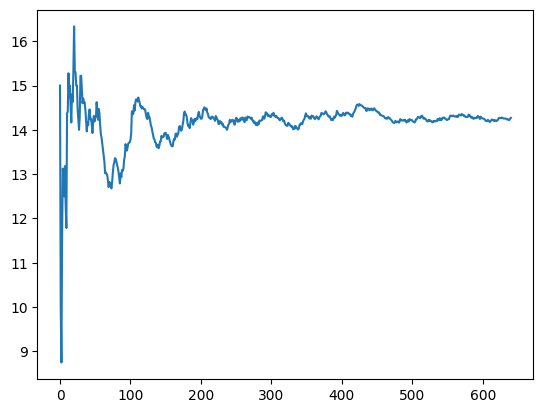

In [10]:
# import gymnasium as gym
# import sys
# import torch
# import numpy as np
# import highway_env
# import warnings
# import time
import pprint
# # from PPO import PPO
# # from PPO import ActorNetwork
# from eval_policy import eval_policy
# highway_env.register_highway_envs()

from rl_agents.agents.common.factory import  load_environment

# warnings.filterwarnings('ignore')
def test(env, actor_model):
	"""
		Tests the model.

		Parameters:
			env - the environment to test the policy on
			actor_model - the actor model to load in

		Return:
			None
	"""
	print(f"Testing {actor_model}", flush=True)

	# If the actor model is not specified, then exit
	if actor_model == '':
		print(f"Didn't specify model file. Exiting.", flush=True)
		sys.exit(0)

	# Extract out dimensions of observation and action spaces
	obs_dim = env.observation_space.shape
	act_dim = env.action_space.n

	# Build our policy the same way we build our actor model in PPO
	policy = ActorNetwork(obs_dim, act_dim)
	policy.load_state_dict(torch.load(actor_model))
	print("eval", policy.eval())
	for name, param in policy.state_dict().items():
		if 'weight' in name:
			print(name, param)
	print("Policy", policy)

	# Evaluate our policy with a separate module, eval_policy, to demonstrate
	# that once we are done training the model/policy with ppo.py, we no longer need
	# ppo.py since it only contains the training algorithm. The model/policy itself exists
	# independently as a binary file that can be loaded in with torch.
	eval_policy(policy=policy, env=env, render=True)

env_config = {
    "id": "intersection-v0",
    "import_module": "highway_env",
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": True,
        "order": "shuffled"
    },
    "destination":"o1", 
		'arrived_reward': 10,
		'collision_reward': -10,
 		'high_speed_reward': 5,

}


env = load_environment(env_config)
env.reset()
pprint.pprint(env.config)

def train():
    print("train")
    #retrain
    PPO(env)

train()
#test(env=env, actor_model="ppo_actor.pth")

